# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
#mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
mnist = fetch_openml('mnist_784', version=1, data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

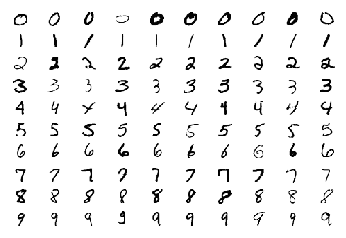

In [32]:
def P1(num_examples=10):
    ### STUDENT START ###

    # For each digit 0 through 9
    for digit in range(10):
        # get num_examples indices of digit from Y
        X_digit = np.where( Y == str(digit))[0]
        digit_index = X_digit[np.random.randint(len(X_digit), size=num_examples)]

        # fetch, format and plot each digit
        for example_digit_idx in range(len(digit_index)):
            example_digit = X[digit_index][example_digit_idx]
            
            # Convert to 28x28 matrix
            matrix_digit = example_digit.reshape(28,28)
            
            # Specify subplot location
            axes = plt.subplot(10, num_examples, 
                               digit*num_examples + example_digit_idx+1, 
                               xticks=[], yticks=[], frame_on=False
                              )
            # Plot it
            axes.imshow(matrix_digit, cmap='Greys',  interpolation='nearest')
    
    plt.show()
            
### STUDENT END ###


P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

    ### STUDENT START ###
    
    results = {}
    for k in k_values:
        cls = KNeighborsClassifier(n_neighbors=k)
        cls.fit(mini_train_data, mini_train_labels)
        
        predictions = []
        
        for data, label in zip(dev_data, dev_labels):
            prediction = cls.predict([data])[0]
            predictions.append([prediction])

        results[k] = cls.score(dev_data, dev_labels)
        
        if k == 1: 
            print("Classification Report for k=1:\n" + classification_report(dev_labels, predictions))

    
    for key, value in results.items():
        print("The accuracy score for k = %i was %0.3f" % (key, value))

    
### STUDENT END ###
              
k_values = [1, 3, 5, 7, 9]
P2(k_values)

Classification Report for k=1:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

The accuracy score for k = 1 was 0.884
The accuracy score for k = 3 was 0.876
The accuracy score for k = 5 was 0.882
The accuracy score for k = 7 was 0.877
The accuracy score for k = 9 was 0.875


ANSWER:

**8 is the most difficult digit**

We have 3 metrics to use to determin which digit is the "most difficult": precision, recall and F1 score.  I will interpret "most difficult" to mean the hardest to predict correctly and ignore other digits that are falsley predicted to be a specific this digit.  So this leaves me with recall as the best metric as it penalizes for false negatives and not false positives.

\begin{equation*}
Recall = \frac{True\ Positive}{True\ Positive + False\ Negative}
\end{equation*}


With k=1, the lowest recall score was 0.77, for the number 8, making it the most difficult digit.  

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    for size in train_sizes:
        tmp_data, tmp_labels = X[:size], Y[:size]
        
        cls = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
        cls.fit(tmp_data, tmp_labels)

        start_time = time.time()
        accuracies.append(cls.score(dev_data, dev_labels))
        total_time = time.time() - start_time
        print("For training size {}, it took {:0.2f} seconds to predict and score".format(size, total_time))
    
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For training size 100, it took 0.12 seconds to predict and score
For training size 200, it took 0.12 seconds to predict and score
For training size 400, it took 0.12 seconds to predict and score
For training size 800, it took 0.22 seconds to predict and score
For training size 1600, it took 0.32 seconds to predict and score
For training size 3200, it took 0.62 seconds to predict and score
For training size 6400, it took 1.23 seconds to predict and score
For training size 12800, it took 2.54 seconds to predict and score
For training size 25000, it took 5.36 seconds to predict and score


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Prediction accuracy for 60,000 using the raw data is 1.2447
Prediction accuracy for 60,000 using the natural log transform on X data is 0.9902


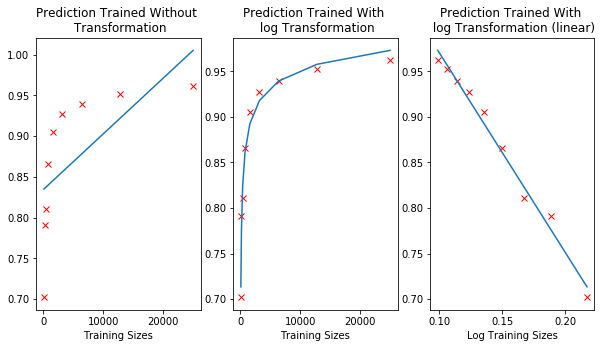

In [6]:
def P4():

### STUDENT START ###
    X = np.asarray(train_sizes).reshape(-1, 1)
    y = np.asarray(accuracies)
    regr = LinearRegression(n_jobs=-1).fit(X, y) 

    loglin_X = 1/np.log(X)
    loglin_regr = LinearRegression(n_jobs=-1).fit(loglin_X, y)
    
    reg_60k = regr.predict(np.array([[60000]]))
    loglin_reg_60k = loglin_regr.predict(np.array([[1/np.log(60000)]]))
    
    print("Prediction accuracy for 60,000 using the raw data is {:0.4f}". format(reg_60k[0]))
    print("Prediction accuracy for 60,000 using the natural log transform on X data is {:0.4f}". format(loglin_reg_60k[0]))
    
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10.0, 5.0))

    ax1.plot(train_sizes, accuracies, 'rx')
    ax1.plot(train_sizes, regr.predict(X))
    ax1.set_title("Prediction Trained Without \n Transformation")
    ax1.set_xlabel("Training Sizes")
    
    ax2.plot(train_sizes, accuracies, 'rx')
    ax2.plot(train_sizes, loglin_regr.predict(loglin_X))
    ax2.set_title("Prediction Trained With \n log Transformation")
    ax2.set_xlabel("Training Sizes")

    ax3.plot(1/np.log(train_sizes), accuracies, 'rx')
    ax3.plot(1/np.log(train_sizes), loglin_regr.predict(loglin_X))
    ax3.set_title("Prediction Trained With \n log Transformation (linear)")
    ax3.set_xlabel("Log Training Sizes")

### STUDENT END ###



P4()

ANSWER:

The predicted accuracy for n=60,000 without any transormation is **1.24**, which is above 1, and impossible probability.  Performing an inverse of the natural log transformation on the training sizes provides a prediction for n=60,000 that is more realistic: **0.9902**.  The relationship between the accuracy and the training size is non-linear and approaches 1.0 somewhere above 25,000 data points in the sample. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

The confusion matrix:
[[105   1   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 102   0   0   0   0   2   1   0]
 [  0   1   0  92   0   2   0   1   1   0]
 [  0   0   0   0  92   0   0   0   0   0]
 [  1   0   0   2   0  83   1   0   0   1]
 [  0   0   0   0   0   1 100   0   1   0]
 [  0   0   1   0   0   0   0 101   0   0]
 [  1   1   2   2   1   0   2   0  85   0]
 [  0   0   0   0   1   0   0   0   0  94]]

The most confused pair are:
3 and 5

Examples of 3's mistaken for 5's and vice versa


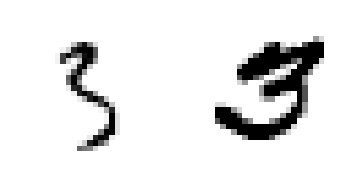

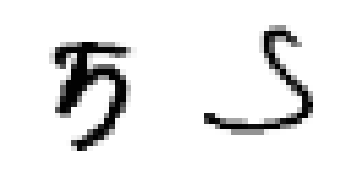

In [7]:
def P5():

### STUDENT START ###
    # Don't need this because the dataset we're using contains each digit, but it's good practice
    matrix_labels = ['0','1','2','3','4','5','6','7','8','9']
    
    X = train_data
    y = train_labels
    X_dev = dev_data
    y_dev = dev_labels
    
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(X, y)
    predicted = knn.predict(X_dev)
    
    cm = confusion_matrix(dev_labels, predicted,
                         labels=matrix_labels)
    

    print("The confusion matrix:")
    print(cm)
    
    print("\nThe most confused pair are:")
    # Adding the confusion matrix to its own transpose ignoring the diagonal
    # reveals the most confused pair with argmax.
    cm_pairs = np.triu(cm, 1) + np.triu(cm.transpose(), 1)
    top_confused_pair_idx = np.unravel_index(cm_pairs.argmax(), cm_pairs.shape)
    top_confused_pair = (matrix_labels[top_confused_pair_idx[0]], matrix_labels[top_confused_pair_idx[1]])
    print("%s and %s" % (top_confused_pair))
    
    # Show examples of most confused pair.
    swaped = dict()
    swaped[top_confused_pair[0]] = (X_dev[np.logical_and(y_dev == top_confused_pair[0],
                           predicted == top_confused_pair[1])])
                 
    swaped[top_confused_pair[1]] = (X_dev[np.logical_and(y_dev == top_confused_pair[1],
                           predicted == top_confused_pair[0])])
                 
    
    print("\nExamples of %s's mistaken for %s's and vice versa" % (top_confused_pair))
    for key, digits in swaped.items():
        plt_idx = 0
        for digit in digits:
            plt_idx += 1
            matrix_digit = digit.reshape(28,28)
            axes = plt.subplot(1, len(digits) , plt_idx, xticks=[], yticks=[], frame_on=False)
            axes.imshow(matrix_digit, cmap='Greys',  interpolation='nearest')
        plt.show()

        

### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [57]:
### STUDENT START ###
# from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import convolve


def blur(X_data):
    #TODO Try an actual normal distribution
    kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])
    blurred_matrix = np.zeros_like(X_data)
    

    for i, new_digit in enumerate(X_data):
        digit = new_digit.reshape((28, 28))
        digit_blur = convolve(digit, kernel/kernel.sum())
        blurred_matrix[i] = digit_blur.ravel()
    
    return blurred_matrix


def P6():
    X_train = train_data
    y_train = train_labels
    X_dev = dev_data
    y_dev = dev_labels
    
    blur_start_time = time.time()
    X_train_blur = blur(X_train)
    X_dev_blur = blur(X_dev)
    print("Blurring took {:0.1f} seconds".format(time.time() - blur_start_time))
        
    models = dict()
    scores = dict()
    times = dict()
    
    models['original training original dev'] = {'X': X_train, 'X_dev': X_dev}
    models['blurred training original dev'] = {'X': X_train_blur, 'X_dev': X_dev}
    models['original training blurred dev'] = {'X': X_train, 'X_dev': X_dev_blur}
    models['blurred training blurred dev'] = {'X': X_train_blur, 'X_dev': X_dev_blur}

    for name, model in models.items():
        loop_start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        knn.fit(model['X'], y_train)
        score = knn.score(model['X_dev'], y_dev)
        scores[name] = score
        times[name] = time.time() - loop_start_time        

    for name, score in scores.items():
        print("The score using {} data scored: {:0.3f} ({:0.1f}s)".format(name, score, times[name]))

### STUDENT END ###

P6()

Blurring took 2.0 seconds
The score using original training original dev data scored: 0.971 (37.8s)
The score using blurred training original dev data scored: 0.974 (25.5s)
The score using original training blurred dev data scored: 0.974 (38.3s)
The score using blurred training blurred dev data scored: 0.978 (22.8s)


ANSWER: The simple gausian filter made a slight improvement over the non-blurred digits.  **The score increased 0.007, from 0.971 to 0.978**. I suspect that since we're increasing the line thickness, we're creating more pixels that have non-zero probability.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [58]:
### STUDENT START ###

def P7():
    X = train_data
    y = train_labels
    
    X_dev = dev_data
    y_dev = dev_labels
    
    X_tri = np.zeros(X.shape)
    X_dev_tri = np.zeros(dev_data.shape)
    X_dev_bin = np.zeros(dev_data.shape)

    
    X_tri[(X >= 0) & (X <=1/3)] = 0
    X_tri[(X > 1/3) & (X <=2/3)] = 1
    X_tri[(X > 2/3)] = 2

    X_dev_tri[(X_dev >= 0) & (X_dev <=1/3)] = 0
    X_dev_tri[(X_dev > 1/3) & (X_dev <=2/3)] = 1
    X_dev_tri[(X_dev > 2/3)] = 2

    X_dev_bin[X_dev > 0] = 1

    
    bin_cls = BernoulliNB(binarize=0)
    bin_cls.fit(X, y)
    
    tri_cls = MultinomialNB()
    tri_cls.fit(X_tri, y)
    
    bin_score = bin_cls.score(X_dev_bin, y_dev)
    tri_score = tri_cls.score(X_dev_tri, y_dev)
    
    print("The score for the Bernoulli Naive Bayes classifier using Binarized data was {:0.3f}".format(bin_score))
    print("The score for the Multinomial Naive Bayes classifier using values 0, 1 or 2 was {:0.3f}".format(tri_score))
    
    
### STUDENT END ###

P7()

The score for the Bernoulli Naive Bayes classifier using Binarized data was 0.828
The score for the Multinomial Naive Bayes classifier using values 0, 1 or 2 was 0.824


ANSWER: The binarized classifier worked slightly better than the multinomial, with a difference of only 0.004.  This could easily fall inside the margin of error.  I expect the binarized version to perform better however, due to the grey areas in these digits are part of the line, and there should not be a penalty for how light or dark they are.  This is similar to the blur method above, we're penalizing for not being dark enough needlessly removing some of our confidence. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [59]:
import warnings
warnings.filterwarnings('ignore')

def P8(alphas):

### STUDENT START ###
    X = train_data
    y = train_labels
    
    X_bin = np.zeros(X.shape)
    
    for i in range(len(X)):
        X_bin[i] = [int(x>0) for x in X[i]]

    bin_cls = BernoulliNB()
    clf = GridSearchCV(bin_cls, alphas, n_jobs=-1)
    clf.fit(X_bin, y)
    
    return clf

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

warnings.filterwarnings('default')

In [60]:
print (nb.best_params_)
for param, score in zip(alphas['alpha'], nb.cv_results_['mean_test_score']):
    print("Using alpha {:0.4f} the accuracy score was {:0.5f}".format(param, score))



{'alpha': 0.0}
Using alpha 0.0000 the accuracy score was 0.83337
Using alpha 0.0001 the accuracy score was 0.83327
Using alpha 0.0010 the accuracy score was 0.83310
Using alpha 0.0100 the accuracy score was 0.83298
Using alpha 0.1000 the accuracy score was 0.83277
Using alpha 0.5000 the accuracy score was 0.83257
Using alpha 1.0000 the accuracy score was 0.83230
Using alpha 2.0000 the accuracy score was 0.83193
Using alpha 10.0000 the accuracy score was 0.83020


ANSWER: The Bernoulli classifier worked best with alpha set to 0.0.  We have samples of each digit, so we were not at risk of having prior expectation of 0 for any class.  Additionally, Laplace smoothing flattens the probablilty distribution towards a uniform distribution, which means that the parameters have decreasing predictive power as alpha increases past a specific point.  Since we're using 60,000 samples, laplace offers little of the benefit smaller datasets would receive.  No smoothing working best is expected as we're otherwise correcting for problems we don't have and still suffering the negative side effects. 

(9) Try training a model using GaussianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [12]:
def P9():

### STUDENT END ###
    X = train_data
    y = train_labels
    
    X_dev = dev_data
    y_dev = dev_labels
    before_cls = GaussianNB().fit(X, y)
    
    count, values = np.unique(X, return_counts=True)
    before_value_count = dict(zip(count, values))
    
    X_noisy = [digit + np.random.normal(0, 0.1, digit.shape) for digit in X]
    noisy_cls = GaussianNB().fit(X_noisy, y)

    
    print("Model score before any changes:{:0.3f}.".format(before_cls.score(X_dev, y_dev)))
    print("In the training set, {:0.1f}% of the pixels are 0.".format(before_value_count[0]/sum(before_value_count.values())*100))
    print("Model score after adding some noise:{:0.3f}.".format(noisy_cls.score(X_dev, y_dev)))
        
    
### STUDENT END ###

gnb = P9()

Model score before any changes:0.586.
In the training set, 80.9% of the pixels are 0.
Model score after adding some noise:0.814.


ANSWER:  Naive Bayes has a assumption of independence. This assumption will be false in the case of any type of characters.  Contiguous lines and whitespace will naturally be strongly correlated, and 81% of the pixels in our data are whitespace.  Removing the correlation by simply adding random noise makes our features a little more independent, increassing the accuracy of our model from 0.59 to 0.81. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

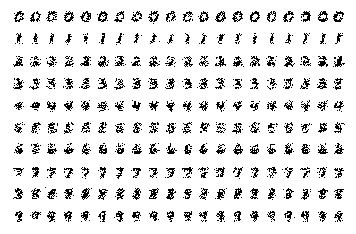

In [13]:
def P10(num_examples):

### STUDENT START ###

    X = train_data
    y = train_labels
    
    cls = BernoulliNB(alpha=1.0).fit(X, y)
    
    for i in range(10):
        digit_class = np.exp(cls.feature_log_prob_[i])
        for j in range(num_examples):
            rand_digit = np.random.rand(28,28)
            matrix_digit_class = digit_class.reshape(28,28)
#             gen_digit = (matrix_digit_class + rand_digit)/2 > 0.5
            gen_digit = (matrix_digit_class > rand_digit)
            axes = plt.subplot(10, num_examples, i*num_examples+j+1, xticks=[], yticks=[], frame_on=False)
            axes.imshow(gen_digit, cmap='Greys',  interpolation='nearest')
            
### STUDENT END ###

P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
def P11(buckets, correct, total):

    
### STUDENT START ###
    X = train_data
    y = train_labels
    
    X_dev = dev_data
    y_dev = dev_labels
    
    cls = BernoulliNB(alpha=1e-10).fit(X, y)
    prediction_probs = cls.predict_proba(X_dev)
    
    for prediction, y_true in zip(prediction_probs, y_dev):
        predicted_digit = np.argmax(prediction)
        digit_probability = prediction[predicted_digit]
        
        for i in range(len(buckets)):
            if digit_probability <= buckets[i]:
                total[i] += 1
                if str(predicted_digit) == y_true:
                    correct[i] += 1
                break # We found our bucket, move on. 
    
    tot_delta = 0
    accuracies = [0 for i in buckets]

    for i in range(len(buckets)):
       accuracy = 0.0
       delta = 0.0
       if (total[i] > 0):
         accuracy = correct[i] / total[i]
         accuracies[i] = accuracy
         delta = (buckets[i]-accuracy)**2
         tot_delta += delta

    print("The sum of the deltas between p(pred) and accuracy is {:0.3f}".format(tot_delta)) 
    print(np.corrcoef(buckets, accuracies))
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   delta = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

The sum of the deltas between p(pred) and accuracy is 1.056
[[1.         0.86013733]
 [0.86013733 1.        ]]
p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  34    accuracy = 0.412
p(pred) <= 0.9990000000000    total =  64    accuracy = 0.500
p(pred) <= 0.9999900000000    total =  57    accuracy = 0.579
p(pred) <= 0.9999999000000    total =  43    accuracy = 0.605
p(pred) <= 0.9999999990000    total =  50    accuracy = 0.660
p(pred) <= 0.9999999999900    total =  50    accuracy = 0.780
p(pred) <= 0.9999999999999    total =  65    accuracy = 0.738
p(pred) <= 1.0000000000000    total = 637    accuracy = 0.950


ANSWER: The classifier is **strongly calibrated**, though likely on the low side of that.  The mean squared error is 1.056 and the correlation in the buckets is 0.86, and because of uneven distribution through the buckets the correlation is likely higher than what's being reported.  

My approach was **non-parametric isotonic regression**.  Finding the value for alpha which minimizes the sum of deltas between the posterior probability and the accuracy done in Question 8 and calculating the mean squared error of the accuracy and buckets in this question for various values for alpha and binarize on the BernoillyNB classifer.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [172]:
def transform(X_data):
    transformed_matrix = np.zeros((len(X_data), (28*28)+3))

    for i, new_digit in enumerate(X_data):
        digit = new_digit.reshape((28, 28))

        # Add a feature that represents its horizontal symmetry
        horz_symmetry = digit[0:14].sum()/digit[15:28].sum()
        
        # Add a feature that represents its vertical symmetry
        half_l = sum([x[:14].sum() for x in digit])
        half_r = sum([x[15:28].sum() for x in digit])
        vert_symmetry = half_l/half_r
        
        # Add a feature that represents its triangular symmetry
        tri_symmetry = np.triu(digit,1).sum()/np.tril(digit,1).sum()
        
        # Combine it all together again
        trans_digit = digit.ravel().tolist()
        trans_digit.append(horz_symmetry)
        trans_digit.append(vert_symmetry)
        trans_digit.append(tri_symmetry)
        transformed_matrix[i] = np.array(trans_digit)
    
    return transformed_matrix

def P12():

### STUDENT START ###
    X = transform(train_data)
    y = train_labels
    
    X_dev = transform(dev_data)
    y_dev = dev_labels

    gaus_cls = GaussianNB(var_smoothing=0.7).fit(X,y)
    bern_cls = BernoulliNB(alpha=1e-10, binarize=0.7).fit(X,y)
    
    print(gaus_cls.score(X_dev, y_dev))
    print(bern_cls.score(X_dev, y_dev))

### STUDENT END ###

P12()

0.702
0.836
